# Finding the Angular Resolution of LHCb
In this notebook we find the angular resolution of the LHCb detector across a variety of different particles. Namely the $\mu$, $e$, $p$ and $K$.

## Defaults and Imports
Import some liraries to make our life easier and set up some constants to be used throughout the document.

In [3]:
import numpy as np
import pandas as pd
import uproot as up
import matplotlib.pyplot as plt

FNAME = "/disk/moose/lhcb/djdt/Lb2L1520mueTuples/MC/2016MD/100FilesCheck/job185-CombDVntuple-15314000-MC2016MD_100F-pKmue-MC.root"
SUFFIX = ":DTT1520me/DecayTree"
FEATURES = ["PX", "TRUEP_X", "PY", "TRUEP_Y", "TRUEP_Z", "PZ", "TRUEPT", "PT"]
CUT_ANGLES = [0, 0.4]

particles = ["L1", "L2"]

## Gathering Necessary Data
Now we have the particles we want to investigate and the features to interrorgate as well as where the data is located we use UpRoot to get these data and store it as a Pandas dataframe. We also do some manipulation in the dataframe to remove duplicate events and calculate the magnitude of the total momentum of a particle, $|p|$.

In [4]:
def get_particles_data(particles, features=FEATURES, fName=FNAME, suffix=SUFFIX):
    """
    Get the features specified in features from the ROOT tuples. Can be specified
    for multiple particles. 

    Parameters:
        particles (list): A list of particles using the ROOT naming convention
        to be interrorgated. For example ['L1', 'K']

    Returns: 
        data (dict): A dictionary of pd.DataFrame for each particle with columns
        labelled according to FEATURES. Keys are particle tuple names.
    """

    data = {}
    for particle in particles:
        fts = [particle + "_" + feature for feature in features]
        with up.open(fName + suffix) as f:
            df = f.arrays(fts, library="pd")
            df.drop_duplicates(keep='first', inplace=True)
            df.columns = features
            data[particle] = df
    return data

## Calculate Angular Features
Now that we can import all of these data we need to manipulate it to find the truth and Monte-Carlo angles relative to the beam axis along with the difference between them. This will allow us to start making plots and binning the data.

In [5]:
def make_angular_features(particles_data, remove_defunct_cols=True, cut_angles=[0, 0.4]):
    """
    Calculate the polar angle relative to the beam axis for the truth and Monte-Carlo data
    for all the dataframes (each unique to a particle) passed in particles_data.

    Parameters:
        particles_data (dict): A dictionary of dataframes with relevant features
        required to calculate the angular features. Each dataframe should contain data only
        relevant to one particle. Keys are particle names.

        remove_defunct_cols (bool, default=True): Remove the columns used during calculation
        from the dataframe. Only used when inplace is True.

        cut_angles (list, defualt=[0, 0.4]): Remove all events who had an angle relative to
        the beam axis exceeding cut_angles[1] and less than cut_angles[0].

    Returns: 
        particles_datas (dict): A dictionary of pd.DataFrame for each particle with columns of features only
        relevant for angular data.
    """

    for particle, data in particles_data.items():
        temp = data.copy()
        temp['P'] = np.sqrt(data['PX']**2 + data['PY']**2 + data['PZ']**2)
        temp['TP'] = np.sqrt(data['TRUEP_X']**2 + data['TRUEP_Y']**2 + data['TRUEP_Z']**2)
        temp['theta'] = np.arcsin(temp['PT']/temp['P'])
        temp['Ttheta'] = np.arcsin(temp['TRUEPT']/temp['TP'])
        temp = temp.loc[(temp['Ttheta'] < cut_angles[1]) & (temp['Ttheta'] > cut_angles[0])]
        temp['dtheta'] = temp['Ttheta'] - temp['theta']
        if remove_defunct_cols:
            temp = temp[['theta', 'Ttheta', 'dtheta']]
        particles_data[particle] = temp
    return particles_data

## Group Angular Data into Bins
Now that we have the angular data we want to group it into bins to make our further analyses easier. Especially as we want to use the same bins across all particles and all analyses. It is much easier to calculate a bin structure now and solely use that.

In [6]:
def get_bin_structure(angular_data, bins=150, cut_angles=CUT_ANGLES):
    """
    Generate evenly spaced bin edges to be used during further calculations and plotting of
    angular data.

    Paramters:
        angular_data (dict): A dictionary containing the angular data dataframe for each particle
        under investigation.

        bins (int, default=150): The number of bins required for the plotting. Note that bins + 1
        bin edges will be returned, inline with matplotlib.pyplot.hist. 

        cut_angles (list, default=CUT_ANGLES): The angular space over which the angular data
        had been previously cut for example [0, 0.4] rad.

    Returns:
        bin_edges (array): An array of length (bins + 1) specifying the edges of each
        bin such that there are bins number of bins fully specified.

        bin_centroids (array): An array of length bins specifying the centroid of
        each of the bins. 
    """

    min_theta, max_theta = np.mean(cut_angles), np.mean(cut_angles)
    for angle_data in angular_data.values():
        if angle_data['Ttheta'].min() < min_theta:
            min_theta = angle_data['Ttheta'].min()
        if angle_data['Ttheta'].max() > max_theta:
            max_theta = angle_data['Ttheta'].max()

    bin_edges = np.linspace(min_theta-(min_theta/10), max_theta+(max_theta/10), bins + 1)
    bin_centroids = np.array([[(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(bin_edges) -1)], 
                    [(bin_edges[1] - bin_edges[0])/2 for i in range(len(bin_edges) -1)]]).T
    return bin_edges, bin_centroids

def group_angular_data_into_bins(angular_data, bin_edges):
    """
    Add another column named bins onto the value of each key in angular_data which
    specifies the bin in the global bin set for which the theta value originates.

    Parameters:
        angular_data (dict): A dictionary of particle tuple names and dataframes
        containing that particles angular data.

        bin_edges (array): An array of bin edges which specify the length of bin_edges
        minus one bins.

    Returns:
        angular_data (dict): An updated instance of angular_data with the bins columns
        added to the value of each key.
    """

    for angle_data in angular_data.values():
        bin_nums = []
        for row in angle_data.iterrows():
            value = row[1].loc['theta']
            bin_num = [n for n, i in enumerate(bin_edges) if i < value][-1]
            bin_nums.append(bin_num)
        angle_data['bin'] = bin_nums

    return angular_data

## Calculate Resolutions Bin Wise
Now we have a bin structure so each bin for all particles is the same and well defined and these data are grouped into their respective bins we can simply calculate the resolution by fitting a normal distribution to all events plotted as a histogram within each bin.

In [124]:
def normal(x, A, mu, std):
    """
    A simple normal distribution probability density function that is not
    normalised. It does however have a variable amplitude.

    Paramaters:
        x (array): An array of x-coordinates to be passed into the 
        Gaussian distribution.

        A (float): The amplitude by which the Gaussian should be scaled by
        such that the PDF = A * normalised PDF.

        mu (float): The mean of the Gaussian distribution.

        std (float): The standard deviation of the Gaussian distribution.

    Returns:
        y (array): An array of same length as x with points corresponding to
        y = f(x).

    """
    return (A/np.sqrt(2*np.pi*(std**2))) * np.exp(-((x-mu)**2)/(2*(std**2)))

def get_binwise_resolution(angular_data, total_bins=None, intra_bins=40):
    """
    Find the mean and standard deviation on a Gaussian distribution when
    it is fitted to a histogram of the events within a specific angular
    data grouped bin.

    Paramters:
        angular_data (dict): A dictionary with keys as particle names and
        values are dataframes with associated angular data.

        total_bins (int, default=None): The number of bins used when doing the 
        initial histogram grouping events into bins. By default this is 150.

        intra_bins (int, default=50): The number of bins with which to
        subdivide each grouped bin.

    Returns:
        fit_params (dict): A dictionary with keys as particle names and
        values that are a 2D array of fit parameters where the fit 
        paramters are A, mu and sigma in that order as given by normal.

    """

    from scipy.optimize import curve_fit
    fit_params, null_bins = {}, {}
    if total_bins is not None:
        all_bins = np.arange(0, total_bins)
    else:
        print('WARN: You have not specified a total number of bins\nDefault to total_bins=150')
        all_bins = np.arange(0, 150)
    for particle in angular_data.keys():
        null_bins[particle] = [bin for bin in all_bins if bin not in angular_data[particle]['bin'].unique()]
    for particle, angle_data in angular_data.items():
        # angle_data is a dataframe for e.g. the muon (L1)
        grouped_angle = angle_data.groupby(['bin'])
        popts = []
        for bin, group in grouped_angle:
            # Within each bin we want to generate a histogram
            this_hist = plt.hist(group['dtheta'].to_numpy(), bins=intra_bins)
            freqs, local_bin_edges = this_hist[0], this_hist[1]
            plt.close() # do not plot the histogram
            local_bin_centres = [(local_bin_edges[i] + local_bin_edges[i+1])/2 for i in range(len(local_bin_edges) - 1)]
            try:
                popt, pcov = curve_fit(normal, local_bin_centres, freqs, p0=[1, np.mean(group['dtheta']), 1e-4])
                popts.append(popt)
            except:
                print(f'Failed to find optimal parameters for bin {bin}')
                popts.append([1, np.mean(group['dtheta']), 0])
        fit_params[particle] = popts
    return fit_params, null_bins

In [125]:
my_angular_data = get_particles_data(particles)
my_angular_data = make_angular_features(my_angular_data)
bin_edges, bin_centroids = get_bin_structure(my_angular_data)
my_angular_data = group_angular_data_into_bins(my_angular_data, bin_edges)


In [126]:
binwise_resolutions, null_bins = get_binwise_resolution(my_angular_data, total_bins=150, intra_bins=40) # something wrong with these values

/cvmfs/lhcbdev.cern.ch/conda/envs/default/2021-09-07_04-06/linux-64/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Failed to find optimal parameters for bin 97
Failed to find optimal parameters for bin 100
Failed to find optimal parameters for bin 102
Failed to find optimal parameters for bin 105
Failed to find optimal parameters for bin 111
Failed to find optimal parameters for bin 112
Failed to find optimal parameters for bin 117
Failed to find optimal parameters for bin 121
Failed to find optimal parameters for bin 125
Failed to find optimal parameters for bin 101
Failed to find optimal parameters for bin 107
Failed to find optimal parameters for bin 109
Failed to find optimal parameters for bin 110
Failed to find optimal parameters for bin 113
Failed to find optimal parameters for bin 114
Failed to find optimal parameters for bin 115


/tmp/ipykernel_3051464/1164561903.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  return (A/np.sqrt(2*np.pi*(std**2))) * np.exp(-((x-mu)**2)/(2*(std**2)))
/tmp/ipykernel_3051464/1164561903.py:22: RuntimeWarning: divide by zero encountered in true_divide
  return (A/np.sqrt(2*np.pi*(std**2))) * np.exp(-((x-mu)**2)/(2*(std**2)))
/tmp/ipykernel_3051464/1164561903.py:22: RuntimeWarning: invalid value encountered in multiply
  return (A/np.sqrt(2*np.pi*(std**2))) * np.exp(-((x-mu)**2)/(2*(std**2)))


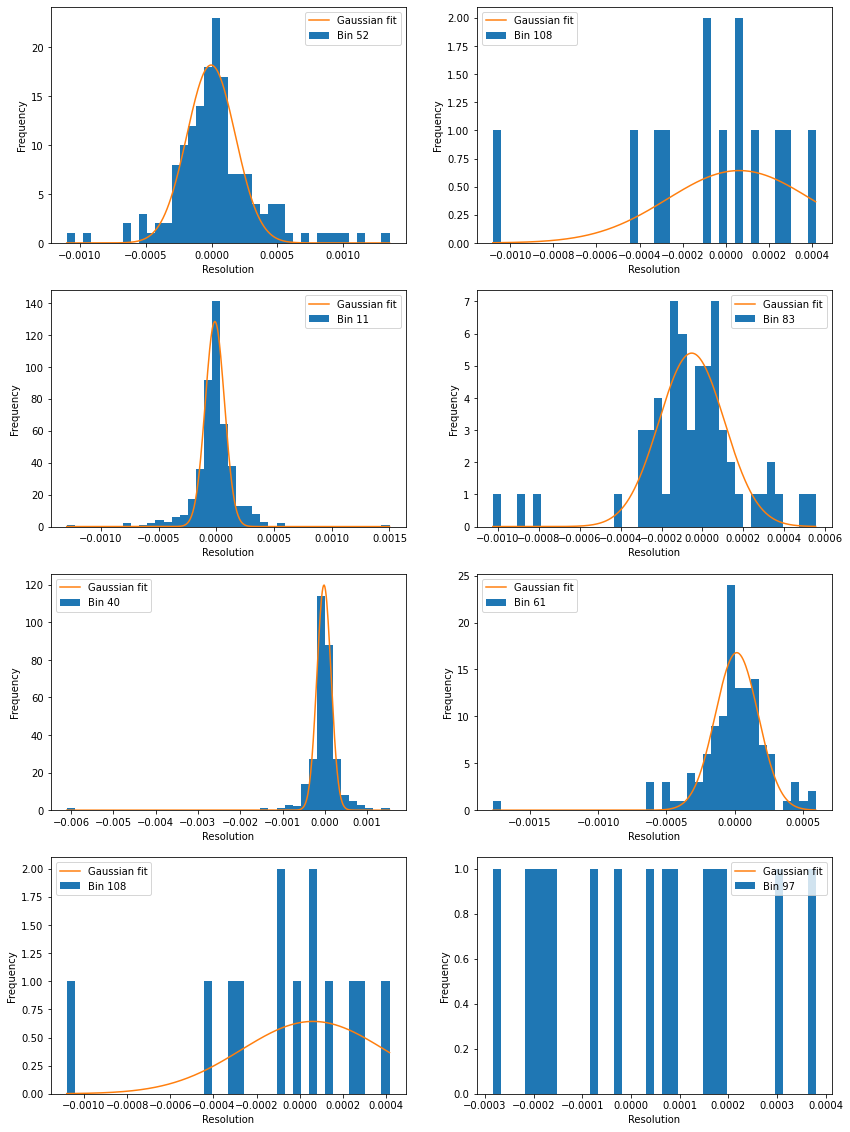

In [128]:
bins = [i for i in np.arange(0, 150) if i not in null_bins['L1']] # The bin IDs of all bins whose fit paramters were computed
d = my_angular_data['L1'].groupby('bin') # We are only looking at the muon now...
np.random.seed = 1
rands = np.round(np.random.rand(4, 2)*np.max(bins)).astype(int) # Some random bins to inspect
fig, ax = plt.subplots(4, 2, figsize=(14, 20))
for i in range(rands.shape[0]): # for i in [0, 1, 2, 3]
    for j in range(rands.shape[1]): # for j in range [0, 1]
        data = d.get_group(rands[i,j])['dtheta'].to_numpy()
        params = binwise_resolutions['L1'][rands[i, j]]
        ax[i][j].hist(data, bins=40, label=f'Bin {rands[i, j]}')
        x = np.linspace(np.min(data), np.max(data), 500)
        ax[i][j].plot(x, normal(x, *params), label='Gaussian fit')
        ax[i][j].set_xlabel('Resolution')
        ax[i][j].set_ylabel('Frequency')
        ax[i][j].legend()
plt.legend()
plt.show()

## Plot Optimised Fit Paramters in Resolution Plot
Up to this stage we have,
- Imported the data we care about for each particle we are investigating, then calculated the features we need and dropped other data.
- Grouped this entire dataset into bins based on an angular space defined by the interval $0\leq\theta\leq0.4$. We used the default number of bins to do this which was 150.
- Assigned a bin to every individual event so we could create a grouped Pandas dataframe and interrogate each bin and the individual events within it.
- Generated a histogram of $\delta\theta$ for all the events within an indiviudal bin (using 50 equally spaced bins). 
- Fit a Gaussian/Normal distribution to these data and returned the fit parameters.

Given this we now need simply to plot our results this is done below using a basic plotting function.

In [21]:
def show_resolution_plot(data, bin_data, null_bins, figsize=(10, 9), xlabel='', ylabel='', title=''):
    """
    Create a simple scatter plot showing the resolution for some variable for any
    number of particles. The particles should all be fully specified within the 
    data dictionary. 

    Paramters:
        data (dict): A dictionary of particle names as keys and associated data the resolution
        and errors on the resolutions from fits previously achieved.

        bin_data (array): A numpy array of shape N x 2 where the first column is the centroids
        from the bins with which data was derived. The second column is the error associated on
        this centroid position.

        null_bins (dict): A dictionary with particle names as keys with associated the values as
        an array of bin numbers which are empty.

        **PLOTTING ARGUMENTS**

    Returns:
        None
        
    """
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    for particle, params in data.items():
        bin_dat = np.delete(bin_data, np.array(null_bins[particle])-1, axis=0)
        bin_err = bin_dat[:, 1]
        bin_centres = bin_dat[:, 0]
        y, yerr = np.array([i[1] for i in params]), np.array([i[2] for i in params])
        ax.errorbar(bin_centres, y, bin_err, yerr, label=particle, fmt='.') # TODO: Fix the angular resolution values they don't seem to fit correctly yet...
    
    ax.set_xlim(-0.1, 0.6)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

    return None

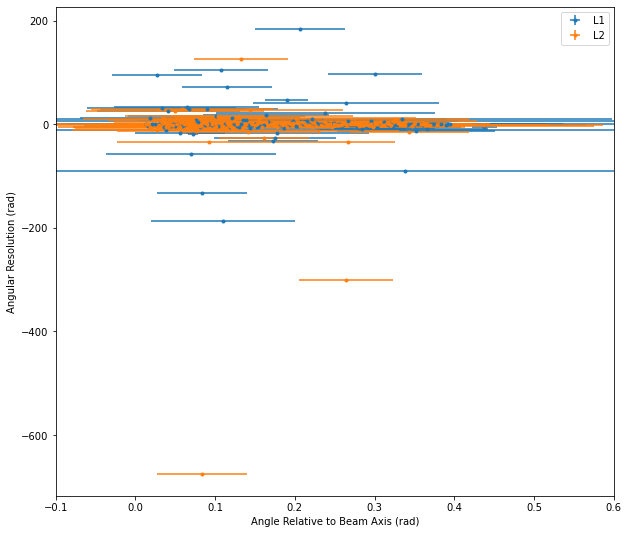

In [22]:

show_resolution_plot(binwise_resolutions, bin_centroids, null_bins, xlabel='Angle Relative to Beam Axis (rad)', ylabel='Angular Resolution (rad)')